# Temporal GFP

In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import statsmodels.api as sm
from datetime import datetime
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index
from backbone import disparity_filter

## load data

In [ ]:
dfall = pd.DataFrame()
for y in range(2012, 2013):  # will change into (2012, 2016 later)
    dfyear = build_df_year(y, with_text=False, with_time=True)
    dfall = dfall.append(dfyear)

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012


## filter data

In [ ]:
# filter out inactive users
# aggr_func = {
#     "subreddit": lambda x: set(x),
#     "submission_id": lambda x: list(x),
#     "comment_id": lambda x: list(x)
#             }
# user_aggr = dfall.groupby("author").agg(aggr_func)  # this should take a while
# user_aggr = user_aggr.reset_index()
# user_aggr["n_subr"] = user_aggr["subreddit"].map(lambda x: len(x))
# user_aggr["n_uniq_subm"] = user_aggr["submission_id"].map(lambda x: len(set(x)))
# user_aggr["n_total_post"] = user_aggr["submission_id"].map(lambda x: len(x))

# user_select1 = user_aggr[(user_aggr["n_subr"]>=2)&(user_aggr["n_total_post"]>=10)][["author"]]
# user_select2 = user_aggr[(user_aggr["n_subr"]>=2)&(user_aggr["n_total_post"]>=20)][["author"]]
# user_select3 = user_aggr[(user_aggr["n_subr"]>=2)&(user_aggr["n_total_post"]>=50)][["author"]]
# user_select4 = user_aggr[(user_aggr["n_subr"]>=5)&(user_aggr["n_total_post"]>=100)][["author"]]
# user_select1.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_10.csv", index=False)
# user_select2.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_20.csv", index=False)
# user_select3.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_50.csv", index=False)
# user_select4.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS5_100.csv", index=False)

In [ ]:
user_select = pd.read_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS5_100.csv")
USERS = user_select["author"].tolist()
dfall = dfall[dfall["author"].isin(USERS)]

# generate user index
user2index = index2user = {}
for i,u in enumerate(USERS):
    user2index[u] = i
    index2user[i] = u

In [5]:
aggr_func = {"author": lambda x: set(x)}
groupby_subm = dfall[["submission_id","author"]].groupby("submission_id").agg(aggr_func).reset_index()
SUBM_USERSET = groupby_subm.set_index("submission_id").to_dict()["author"]

# later only focus on multi-user submissions
groupby_subm["n_author"] = groupby_subm["author"].map(lambda x: len(x))
SU_SUBM = groupby_subm[groupby_subm["n_author"]==1]["submission_id"].tolist()
df_multiuser_subm = dfall[~dfall["submission_id"].isin(SU_SUBM)]

## build temporal dataframe

In [6]:
# start and end time of submissions
aggr_func = {"created_utc": [np.min, np.max]}
SUBM_TIME = dfall[["submission_id","created_utc"]].groupby("submission_id").agg(aggr_func)
SUBM_TIME.columns = SUBM_TIME.columns.droplevel(0)
SUBM_TIME_DICT = SUBM_TIME.to_dict()

In [7]:
TOX_DF = dfall[["author","created_utc","toxicity"]].sort_values(by=["author", "created_utc"])
TOX_DF = TOX_DF.reset_index().drop(columns=["index"])
# TOX_DICT = TOX_DF.set_index("author").to_dict()

aggr_func = {"created_utc":lambda x: list(x), "toxicity":lambda x: list(x)}
TOX_DF_AGGR = TOX_DF.groupby("author").agg(aggr_func)
TOX_DICT = TOX_DF_AGGR.to_dict()

In [8]:
TOX_DF

,author,created_utc,toxicity
0,---,1329737283,0.148685
1,---,1330298171,0.066676
2,---,1331226144,0.116003
3,---,1332037663,0.658958
4,---,1332052813,0.796161
...,...,...,...
12687475,zzzzz94,1451586048,0.242543
12687476,zzzzz94,1451589050,0.274770
12687477,zzzzz94,1451589108,0.084028
12687478,zzzzz94,1451595740,0.071906


In [8]:
def calculate_temp_toxicity(user, start, end):
    times = TOX_DICT["created_utc"][user]
    scores = TOX_DICT["toxicity"][user]
    tox_ls = []
    for (t,s) in zip(times, scores):
        if t>=start and t<=end and str(s)!="nan":
            tox_ls.append(s)
    return np.mean(tox_ls)

# def calculate_temp_toxicity(user, start, end):  --> df indexing is too slow
#     df = TOX_DF[(TOX_DF["author"]==user)&(TOX_DF["created_utc"]>=start)&(TOX_DF["created_utc"]<=end)]
#     if len(df)>0: avg_tox = np.mean(df["toxicity"])
#     else: avg_tox = np.NaN
#     return avg_tox

In [10]:
dfall = dfall.sort_values(by=["author", "created_utc"])
dfall["unique_id"] = range(0, len(dfall))
dfall = dfall.reset_index().drop(columns=["index"])

In [11]:
aggr_func = {"unique_id": lambda x: list(x)}
groupby_user = dfall[["unique_id","author"]].groupby("author").agg(aggr_func)
USER_POST_DICT = groupby_user.to_dict()["unique_id"]

In [12]:
uniq2subm = dfall[["unique_id","submission_id"]].set_index("unique_id").to_dict()["submission_id"]

In [13]:
# step = 0.1
# temp_me_tox = np.zeros((len(USERS), int(1/step)))
# temp_env_tox = np.zeros((len(USERS), int(1/step)))
# temp_gfp = np.zeros((len(USERS), int(1/step)))
# for j,u in enumerate(USERS):
#     if j%10==0: print("progress:", j/len(USERS))
# #     print("user:", j)
#     all_posts = USER_POST_DICT[u]
#     for i in range(int(1/step)):
        
# #         print("computing window...")
#         post_window = all_posts[math.floor(step*i*len(all_posts)):math.floor(step*(i+1)*len(all_posts))]
#         subm_window = list(set([uniq2subm[x] for x in post_window]))
#         start_time = SUBM_TIME_DICT["amin"][subm_window[0]]
#         end_time = SUBM_TIME_DICT["amax"][subm_window[-1]]
        
# #         print("getting neighbors...")
#         temp_neighbors = []
#         for subm in subm_window:
#             temp_neighbors += SUBM_USERSET[subm]
#         temp_neighbors = set(temp_neighbors)

# #         print("calculating toxicity...")
#         my_tox = calculate_temp_toxicity(u, start_time, end_time)
#         env_tox = [calculate_temp_toxicity(nei, start_time, end_time) for nei in temp_neighbors]
#         env_tox = np.mean(env_tox)
        
#         temp_me_tox[user2index[u],i] = my_tox
#         temp_env_tox[user2index[u],i] = env_tox
#         if env_tox > my_tox:
#             temp_gfp[user2index[u],i] = 1  

progress: 0.0
progress: 0.00026116479498563595
progress: 0.0005223295899712719
progress: 0.0007834943849569079
progress: 0.0010446591799425438
progress: 0.0013058239749281796
progress: 0.0015669887699138157
progress: 0.0018281535648994515
progress: 0.0020893183598850876
progress: 0.0023504831548707234
progress: 0.0026116479498563593
progress: 0.002872812744841995
progress: 0.0031339775398276314
progress: 0.0033951423348132673
progress: 0.003656307129798903
progress: 0.003917471924784539
progress: 0.004178636719770175
progress: 0.004439801514755811
progress: 0.004700966309741447
progress: 0.004962131104727083
progress: 0.005223295899712719
progress: 0.005484460694698354
progress: 0.00574562548968399
progress: 0.006006790284669626
progress: 0.006267955079655263
progress: 0.006529119874640899
progress: 0.0067902846696265345
progress: 0.00705144946461217
progress: 0.007312614259597806
progress: 0.007573779054583442
progress: 0.007834943849569079
progress: 0.008096108644554715
progress: 0.0

progress: 0.07051449464612171
progress: 0.07077565944110734
progress: 0.07103682423609298
progress: 0.0712979890310786
progress: 0.07155915382606425
progress: 0.07182031862104989
progress: 0.07208148341603551
progress: 0.07234264821102115
progress: 0.0726038130060068
progress: 0.07286497780099242
progress: 0.07312614259597806
progress: 0.0733873073909637
progress: 0.07364847218594933
progress: 0.07390963698093497
progress: 0.0741708017759206
progress: 0.07443196657090624
progress: 0.07469313136589188
progress: 0.07495429616087751
progress: 0.07521546095586315
progress: 0.07547662575084879
progress: 0.07573779054583442
progress: 0.07599895534082006
progress: 0.07626012013580569
progress: 0.07652128493079133
progress: 0.07678244972577697
progress: 0.0770436145207626
progress: 0.07730477931574824
progress: 0.07756594411073388
progress: 0.0778271089057195
progress: 0.07808827370070515
progress: 0.07834943849569079
progress: 0.07861060329067641
progress: 0.07887176808566206
progress: 0.0791

progress: 0.1423348132671716
progress: 0.1425959780621572
progress: 0.14285714285714285
progress: 0.1431183076521285
progress: 0.14337947244711413
progress: 0.14364063724209977
progress: 0.1439018020370854
progress: 0.14416296683207103
progress: 0.14442413162705667
progress: 0.1446852964220423
progress: 0.14494646121702795
progress: 0.1452076260120136
progress: 0.1454687908069992
progress: 0.14572995560198485
progress: 0.1459911203969705
progress: 0.14625228519195613
progress: 0.14651344998694177
progress: 0.1467746147819274
progress: 0.14703577957691302
progress: 0.14729694437189866
progress: 0.1475581091668843
progress: 0.14781927396186995
progress: 0.1480804387568556
progress: 0.1483416035518412
progress: 0.14860276834682684
progress: 0.14886393314181248
progress: 0.14912509793679812
progress: 0.14938626273178376
progress: 0.14964742752676938
progress: 0.14990859232175502
progress: 0.15016975711674066
progress: 0.1504309219117263
progress: 0.15069208670671194
progress: 0.15095325150

progress: 0.21467746147819275
progress: 0.21493862627317836
progress: 0.215199791068164
progress: 0.21546095586314964
progress: 0.21572212065813529
progress: 0.21598328545312093
progress: 0.21624445024810657
progress: 0.21650561504309218
progress: 0.21676677983807782
progress: 0.21702794463306346
progress: 0.2172891094280491
progress: 0.21755027422303475
progress: 0.21781143901802036
progress: 0.218072603813006
progress: 0.21833376860799164
progress: 0.21859493340297728
progress: 0.21885609819796292
progress: 0.21911726299294856
progress: 0.21937842778793418
progress: 0.21963959258291982
progress: 0.21990075737790546
progress: 0.2201619221728911
progress: 0.22042308696787674
progress: 0.22068425176286235
progress: 0.220945416557848
progress: 0.22120658135283364
progress: 0.22146774614781928
progress: 0.22172891094280492
progress: 0.22199007573779053
progress: 0.22225124053277617
progress: 0.22251240532776181
progress: 0.22277357012274746
progress: 0.2230347349177331
progress: 0.2232958

progress: 0.28728127448419954
progress: 0.28754243927918516
progress: 0.2878036040741708
progress: 0.28806476886915644
progress: 0.28832593366414205
progress: 0.2885870984591277
progress: 0.28884826325411334
progress: 0.289109428049099
progress: 0.2893705928440846
progress: 0.28963175763907023
progress: 0.2898929224340559
progress: 0.2901540872290415
progress: 0.2904152520240272
progress: 0.2906764168190128
progress: 0.2909375816139984
progress: 0.2911987464089841
progress: 0.2914599112039697
progress: 0.29172107599895536
progress: 0.291982240793941
progress: 0.2922434055889266
progress: 0.29250457038391225
progress: 0.29276573517889787
progress: 0.29302689997388354
progress: 0.29328806476886915
progress: 0.2935492295638548
progress: 0.29381039435884043
progress: 0.29407155915382605
progress: 0.2943327239488117
progress: 0.2945938887437973
progress: 0.294855053538783
progress: 0.2951162183337686
progress: 0.2953773831287542
progress: 0.2956385479237399
progress: 0.2958997127187255
prog

progress: 0.360146252285192
progress: 0.3604074170801776
progress: 0.3606685818751632
progress: 0.3609297466701489
progress: 0.3611909114651345
progress: 0.36145207626012016
progress: 0.36171324105510577
progress: 0.3619744058500914
progress: 0.36223557064507705
progress: 0.36249673544006267
progress: 0.36275790023504834
progress: 0.36301906503003395
progress: 0.36328022982501956
progress: 0.36354139462000523
progress: 0.36380255941499084
progress: 0.3640637242099765
progress: 0.3643248890049621
progress: 0.36458605379994774
progress: 0.3648472185949334
progress: 0.365108383389919
progress: 0.3653695481849047
progress: 0.3656307129798903
progress: 0.365891877774876
progress: 0.3661530425698616
progress: 0.3664142073648472
progress: 0.36667537215983287
progress: 0.3669365369548185
progress: 0.36719770174980415
progress: 0.36745886654478976
progress: 0.3677200313397754
progress: 0.36798119613476105
progress: 0.36824236092974666
progress: 0.36850352572473233
progress: 0.36876469051971794


progress: 0.43301123008618436
progress: 0.43327239488117003
progress: 0.43353355967615564
progress: 0.4337947244711413
progress: 0.4340558892661269
progress: 0.43431705406111254
progress: 0.4345782188560982
progress: 0.4348393836510838
progress: 0.4351005484460695
progress: 0.4353617132410551
progress: 0.4356228780360407
progress: 0.4358840428310264
progress: 0.436145207626012
progress: 0.43640637242099767
progress: 0.4366675372159833
progress: 0.4369287020109689
progress: 0.43718986680595456
progress: 0.4374510316009402
progress: 0.43771219639592585
progress: 0.43797336119091146
progress: 0.4382345259858971
progress: 0.43849569078088274
progress: 0.43875685557586835
progress: 0.439018020370854
progress: 0.43927918516583964
progress: 0.4395403499608253
progress: 0.4398015147558109
progress: 0.44006267955079653
progress: 0.4403238443457822
progress: 0.4405850091407678
progress: 0.4408461739357535
progress: 0.4411073387307391
progress: 0.4413685035257247
progress: 0.4416296683207104
prog

progress: 0.5061373726821624
progress: 0.506398537477148
progress: 0.5066597022721337
progress: 0.5069208670671194
progress: 0.507182031862105
progress: 0.5074431966570906
progress: 0.5077043614520763
progress: 0.5079655262470619
progress: 0.5082266910420475
progress: 0.5084878558370332
progress: 0.5087490206320188
progress: 0.5090101854270045
progress: 0.5092713502219901
progress: 0.5095325150169757
progress: 0.5097936798119613
progress: 0.5100548446069469
progress: 0.5103160094019327
progress: 0.5105771741969183
progress: 0.5108383389919039
progress: 0.5110995037868895
progress: 0.5113606685818751
progress: 0.5116218333768608
progress: 0.5118829981718465
progress: 0.5121441629668321
progress: 0.5124053277618177
progress: 0.5126664925568033
progress: 0.512927657351789
progress: 0.5131888221467746
progress: 0.5134499869417603
progress: 0.5137111517367459
progress: 0.5139723165317315
progress: 0.5142334813267172
progress: 0.5144946461217028
progress: 0.5147558109166884
progress: 0.51501

progress: 0.580308174458083
progress: 0.5805693392530686
progress: 0.5808305040480544
progress: 0.58109166884304
progress: 0.5813528336380256
progress: 0.5816139984330112
progress: 0.5818751632279968
progress: 0.5821363280229825
progress: 0.5823974928179682
progress: 0.5826586576129538
progress: 0.5829198224079394
progress: 0.583180987202925
progress: 0.5834421519979107
progress: 0.5837033167928963
progress: 0.583964481587882
progress: 0.5842256463828676
progress: 0.5844868111778532
progress: 0.5847479759728389
progress: 0.5850091407678245
progress: 0.5852703055628101
progress: 0.5855314703577957
progress: 0.5857926351527815
progress: 0.5860537999477671
progress: 0.5863149647427527
progress: 0.5865761295377383
progress: 0.5868372943327239
progress: 0.5870984591277096
progress: 0.5873596239226953
progress: 0.5876207887176809
progress: 0.5878819535126665
progress: 0.5881431183076521
progress: 0.5884042831026378
progress: 0.5886654478976234
progress: 0.588926612692609
progress: 0.58918777

progress: 0.6544789762340036
progress: 0.6547401410289893
progress: 0.655001305823975
progress: 0.6552624706189606
progress: 0.6555236354139462
progress: 0.6557848002089318
progress: 0.6560459650039174
progress: 0.6563071297989032
progress: 0.6565682945938888
progress: 0.6568294593888744
progress: 0.65709062418386
progress: 0.6573517889788456
progress: 0.6576129537738313
progress: 0.657874118568817
progress: 0.6581352833638026
progress: 0.6583964481587882
progress: 0.6586576129537738
progress: 0.6589187777487595
progress: 0.6591799425437451
progress: 0.6594411073387307
progress: 0.6597022721337163
progress: 0.659963436928702
progress: 0.6602246017236877
progress: 0.6604857665186733
progress: 0.6607469313136589
progress: 0.6610080961086445
progress: 0.6612692609036301
progress: 0.6615304256986159
progress: 0.6617915904936015
progress: 0.6620527552885871
progress: 0.6623139200835727
progress: 0.6625750848785583
progress: 0.662836249673544
progress: 0.6630974144685297
progress: 0.66335857

progress: 0.7286497780099243
progress: 0.7289109428049099
progress: 0.7291721075998955
progress: 0.7294332723948812
progress: 0.7296944371898668
progress: 0.7299556019848524
progress: 0.730216766779838
progress: 0.7304779315748238
progress: 0.7307390963698094
progress: 0.731000261164795
progress: 0.7312614259597806
progress: 0.7315225907547662
progress: 0.731783755549752
progress: 0.7320449203447376
progress: 0.7323060851397232
progress: 0.7325672499347088
progress: 0.7328284147296944
progress: 0.7330895795246801
progress: 0.7333507443196657
progress: 0.7336119091146514
progress: 0.733873073909637
progress: 0.7341342387046226
progress: 0.7343954034996083
progress: 0.7346565682945939
progress: 0.7349177330895795
progress: 0.7351788978845651
progress: 0.7354400626795508
progress: 0.7357012274745365
progress: 0.7359623922695221
progress: 0.7362235570645077
progress: 0.7364847218594933
progress: 0.7367458866544789
progress: 0.7370070514494647
progress: 0.7372682162444503
progress: 0.737529

progress: 0.8028205797858449
progress: 0.8030817445808305
progress: 0.8033429093758161
progress: 0.8036040741708018
progress: 0.8038652389657874
progress: 0.804126403760773
progress: 0.8043875685557587
progress: 0.8046487333507443
progress: 0.80490989814573
progress: 0.8051710629407156
progress: 0.8054322277357012
progress: 0.8056933925306868
progress: 0.8059545573256724
progress: 0.8062157221206582
progress: 0.8064768869156438
progress: 0.8067380517106294
progress: 0.806999216505615
progress: 0.8072603813006006
progress: 0.8075215460955864
progress: 0.807782710890572
progress: 0.8080438756855576
progress: 0.8083050404805432
progress: 0.8085662052755288
progress: 0.8088273700705145
progress: 0.8090885348655001
progress: 0.8093496996604858
progress: 0.8096108644554714
progress: 0.8098720292504571
progress: 0.8101331940454427
progress: 0.8103943588404283
progress: 0.8106555236354139
progress: 0.8109166884303995
progress: 0.8111778532253853
progress: 0.8114390180203709
progress: 0.8117001

progress: 0.8769913815617655
progress: 0.8772525463567511
progress: 0.8775137111517367
progress: 0.8777748759467224
progress: 0.878036040741708
progress: 0.8782972055366937
progress: 0.8785583703316793
progress: 0.8788195351266649
progress: 0.8790806999216506
progress: 0.8793418647166362
progress: 0.8796030295116218
progress: 0.8798641943066075
progress: 0.8801253591015931
progress: 0.8803865238965788
progress: 0.8806476886915644
progress: 0.88090885348655
progress: 0.8811700182815356
progress: 0.8814311830765212
progress: 0.881692347871507
progress: 0.8819535126664926
progress: 0.8822146774614782
progress: 0.8824758422564638
progress: 0.8827370070514494
progress: 0.8829981718464351
progress: 0.8832593366414208
progress: 0.8835205014364064
progress: 0.883781666231392
progress: 0.8840428310263776
progress: 0.8843039958213633
progress: 0.8845651606163489
progress: 0.8848263254113345
progress: 0.8850874902063202
progress: 0.8853486550013058
progress: 0.8856098197962915
progress: 0.8858709

progress: 0.9511621833376861
progress: 0.9514233481326717
progress: 0.9516845129276573
progress: 0.9519456777226429
progress: 0.9522068425176287
progress: 0.9524680073126143
progress: 0.9527291721075999
progress: 0.9529903369025855
progress: 0.9532515016975711
progress: 0.9535126664925568
progress: 0.9537738312875425
progress: 0.9540349960825281
progress: 0.9542961608775137
progress: 0.9545573256724994
progress: 0.954818490467485
progress: 0.9550796552624706
progress: 0.9553408200574562
progress: 0.9556019848524419
progress: 0.9558631496474276
progress: 0.9561243144424132
progress: 0.9563854792373988
progress: 0.9566466440323844
progress: 0.95690780882737
progress: 0.9571689736223558
progress: 0.9574301384173414
progress: 0.957691303212327
progress: 0.9579524680073126
progress: 0.9582136328022982
progress: 0.9584747975972839
progress: 0.9587359623922695
progress: 0.9589971271872552
progress: 0.9592582919822408
progress: 0.9595194567772264
progress: 0.9597806215722121
progress: 0.960041

In [14]:
temp_me_tox.dump(ROOTPATH + "output/matrix/temp_me_tox.dat")
temp_env_tox.dump(ROOTPATH + "output/matrix/temp_env_tox.dat")
temp_gfp.dump(ROOTPATH + "output/matrix/temp_gfp.dat")

# uncomment if reading from saved matrices
# temp_me_tox = np.load(ROOTPATH + "output/matrix/temp_me_tox.dat", allow_pickle=True)
# temp_env_tox = np.load(ROOTPATH + "output/matrix/temp_env_tox.dat", allow_pickle=True)
# temp_gfp = np.load(ROOTPATH + "output/matrix/temp_gfp.dat", allow_pickle=True)

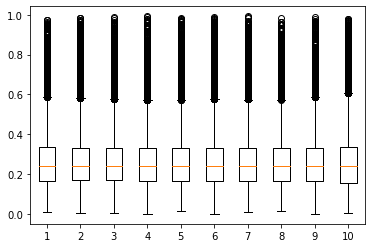

In [24]:
fig,ax = plt.subplots()
data = []
for i in range(10):
    data.append([x for x in temp_me_tox.T[i] if str(x)!="nan"])
ax.boxplot(data)
plt.show()

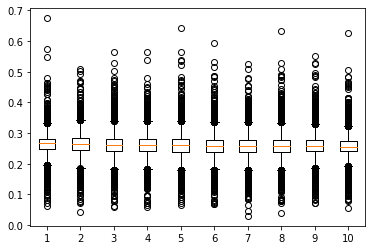

In [25]:
fig,ax = plt.subplots()
data = []
for i in range(10):
    data.append([x for x in temp_env_tox.T[i] if str(x)!="nan"])
ax.boxplot(data)
plt.show()

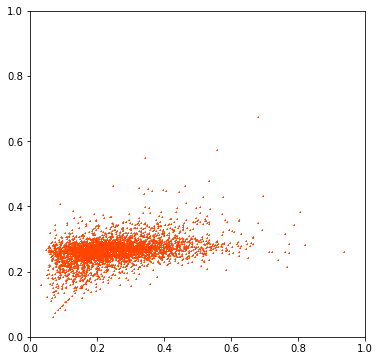

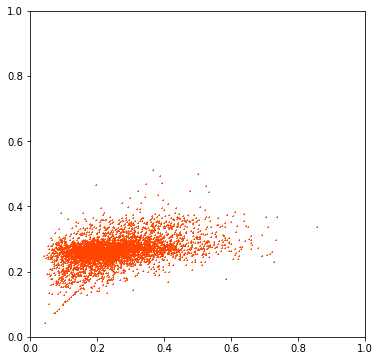

In [44]:
for i in range(2):
    fig,ax = plt.subplots(figsize=(6,6))
    x = [t for t in temp_me_tox.T[i]]
    y = [t for t in temp_env_tox.T[i]]
    new_x = []
    new_y = []
    for a,b in zip(x,y):
        if str(a)!="nan" and str(b)!="nan":
            new_x.append(a)
            new_y.append(b)
    plt.scatter(x,y, cmap="Reds", s=1, marker="+", color="#FF4500")
#     plt.hist2d(new_x, new_y, (80,80), cmap="Reds", cmin=1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.show()

In [42]:
temp_me_tox

array([[       nan, 0.41044288, 0.44164671, ..., 0.37444601, 0.37444601,
        0.31329593],
       [0.32029748,        nan, 0.30956134, ..., 0.27327388, 0.28860421,
               nan],
       [0.31181223, 0.23822099, 0.20309604, ..., 0.45600069, 0.28960175,
        0.12609245],
       ...,
       [0.13191625, 0.10360441, 0.32220262, ..., 0.25723722, 0.28281183,
        0.25268489],
       [0.55629065, 0.32079877, 0.38657248, ..., 0.22097623, 0.20386399,
        0.12631718],
       [       nan, 0.23243199, 0.44238012, ..., 0.23774475, 0.23774475,
        0.18784136]])

In [46]:
temp_env_tox

array([[       nan,        nan, 0.36265692, ..., 0.30069854, 0.29144277,
        0.26104617],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.26903358,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.23704203, 0.23704203,
               nan]])

In [40]:
temp_gfp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<ErrorbarContainer object of 3 artists>

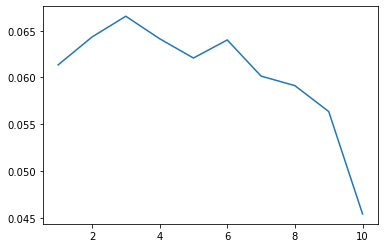

In [22]:
plt.errorbar(x=np.arange(1,11), 
             y=np.mean(temp_gfp, axis=0),
#              yerr=np.std(temp_gfp, axis=0)
            )

In [19]:
np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

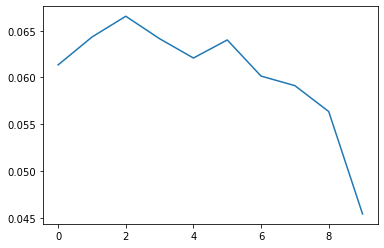

In [18]:
plt.plot(np.mean(temp_gfp, axis=0))
plt.show()

## temporal GFP

In [ ]:
# for each user, examine whether GFP hold true through 10 timepoints in their lifetime

In [15]:
utc2datetime(1325384477)

datetime.datetime(2012, 1, 1, 2, 21, 17)

## misc

In [ ]:
# created time of submissions
SUBM_TIME = dfall[dfall["comment_id"].isna()][["submission_id","created_utc"]]
SUBM_TIME = SUBM_TIME.reset_index().drop(columns=["index"])  # 751577

In [ ]:
# last reply time of submissions
SUBM_TIME2 = dfall[dfall["comment_id"].notna()][["submission_id","created_utc"]].groupby("submission_id").max()
SUBM_TIME2 = SUBM_TIME2.reset_index().rename(columns={"created_utc":"last_utc"})
SUBM_TIME = SUBM_TIME.merge(SUBM_TIME2, on="submission_id", how="left")
# SUBM_TIME["last_utc"] = SUBM_TIME["last_utc"].map(lambda x: int(x) if str(x) != "nan" else np.NaN)
SUBM_TIME_DICT = SUBM_TIME.set_index("submission_id").to_dict()